# 숫자 멀티 라벨 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# annotation

In [3]:
annot_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/2/data/annotations.csv')
annot_df

,filename,filepath,classes
0,image_26645.jpg,images/image_26645.jpg,"[3, 5]"
1,image_24828.jpg,images/image_24828.jpg,"[1, 3]"
2,image_12280.jpg,images/image_12280.jpg,"[4, 0]"
3,image_7446.jpg,images/image_7446.jpg,"[9, 5]"
4,image_15460.jpg,images/image_15460.jpg,[2]
...,...,...,...
1995,image_22670.jpg,images/image_22670.jpg,"[6, 1]"
1996,image_4461.jpg,images/image_4461.jpg,"[8, 2]"
1997,image_29189.jpg,images/image_29189.jpg,"[2, 6]"
1998,image_15688.jpg,images/image_15688.jpg,"[4, 1]"


In [4]:
annot_df['classes'].tolist()

['[3, 5]',
 '[1, 3]',
 '[4, 0]',
 '[9, 5]',
 '[2]',
 '[1]',
 '[7, 0]',
 '[0, 1]',
 '[4, 7]',
 '[5, 2]',
 '[4, 0]',
 '[5, 0]',
 '[2, 8]',
 '[4, 2]',
 '[3, 8]',
 '[2, 9]',
 '[2, 1]',
 '[5, 2]',
 '[5, 3]',
 '[5, 7]',
 '[0, 8]',
 '[9, 3]',
 '[0, 1]',
 '[1]',
 '[2, 3]',
 '[9, 0]',
 '[2, 3]',
 '[8, 0]',
 '[2, 9]',
 '[2, 9]',
 '[0, 8]',
 '[1, 3]',
 '[4, 5]',
 '[4, 9]',
 '[3, 7]',
 '[2, 9]',
 '[8, 7]',
 '[0, 1]',
 '[2, 0]',
 '[7, 1]',
 '[8, 4]',
 '[3, 4]',
 '[5, 4]',
 '[5, 0]',
 '[8, 4]',
 '[9, 6]',
 '[2, 7]',
 '[1, 9]',
 '[4, 0]',
 '[1, 7]',
 '[0]',
 '[7, 8]',
 '[1, 0]',
 '[4, 3]',
 '[8, 3]',
 '[4, 5]',
 '[5, 0]',
 '[3, 4]',
 '[6, 0]',
 '[2, 1]',
 '[7, 9]',
 '[9, 2]',
 '[9, 5]',
 '[5]',
 '[2, 4]',
 '[5, 2]',
 '[2, 1]',
 '[9, 1]',
 '[8, 1]',
 '[5, 2]',
 '[6, 2]',
 '[9, 7]',
 '[4, 6]',
 '[9, 2]',
 '[7, 2]',
 '[4, 7]',
 '[0, 6]',
 '[6, 3]',
 '[6, 1]',
 '[8]',
 '[1, 4]',
 '[1]',
 '[7, 2]',
 '[1, 8]',
 '[8, 7]',
 '[4, 5]',
 '[6, 4]',
 '[1, 4]',
 '[8, 1]',
 '[9, 3]',
 '[8, 4]',
 '[0, 5]',
 '[6, 9]'

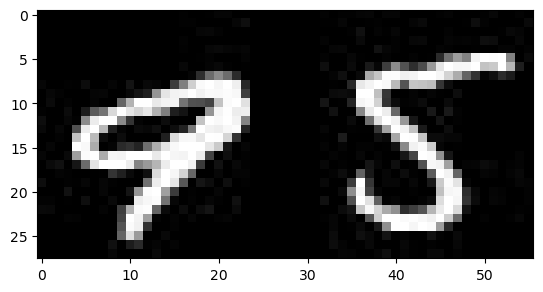

In [5]:
tmp = Image.open('/Users/kimhongseok/cv_79_projects/part1/chapter3/2/data/images/image_7.jpg').convert('RGB')
plt.imshow(tmp)

# dataset, dataloader

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annot_df, transforms, class_list, root_path):
        super().__init__()
        self.data = [list(annot_df['filename'].tolist()), list(annot_df['classes'].tolist())]
        self.transforms = transforms
        self.class_list = class_list
        self.root_path = root_path

    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.data[0][idx])
        img = Image.open(img_path).convert('RGB')
        img = self.transforms(img)
        cls = self.data[1][idx]
        cls = cls.replace('[', '')
        cls = cls.replace(']', '')
        cls = cls.split(',')
        cls = [int(c) for c in cls]
        cls = torch.nn.functional.one_hot(torch.tensor(cls), len(self.class_list)).sum(dim=0).to(torch.float)
        
        return img, cls

In [7]:
transforms = T.Compose([
    T.ToTensor()
])
class_list = [i for i in range(10)]
root_path = '/Users/kimhongseok/cv_79_projects/part1/chapter3/2/data/images'

total_dataset = CustomDataset(annot_df, transforms, class_list, root_path)

tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])

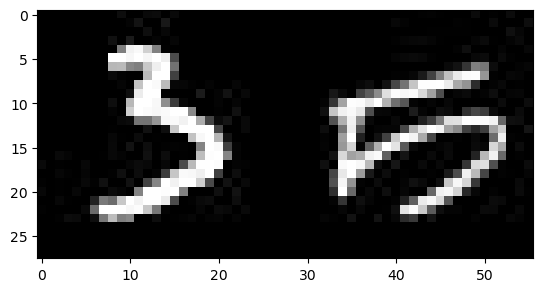

In [8]:
plt.imshow(total_dataset[0][0].permute(1, 2, 0))
total_dataset[0][1]

In [9]:
total_num = len(total_dataset)
print(total_num)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num, test_num])
print(len(train_dataset), len(valid_dataset), len(test_dataset))

2000
1600 200 200


In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=50, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

# train, eval

In [11]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_f1_score = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1_score

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs)>threshold).float()
            loss = criterion(outputs, labels)

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_f1_score = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1_score

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_f1_score = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1_score = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1 Score: {train_f1_score}, Valid Loss: {valid_loss}, Valid F1 Score: {valid_f1_score}')

    return model

# model

In [12]:
model = timm.create_model(
    'resnet18',
    num_classes=10,
    pretrained=True
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [13]:
'''
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.layer4.parameters():
    parameter.requires_grad = True

for parameter in model.fc.parameters():
    parameter.requires_grad = True
'''

'\nfor parameter in model.parameters():\n    parameter.requires_grad = False\n\nfor parameter in model.layer4.parameters():\n    parameter.requires_grad = True\n\nfor parameter in model.fc.parameters():\n    parameter.requires_grad = True\n'

# 학습

In [14]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 20)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.49964133743196726, Train F1 Score: 0.12887077260731108, Valid Loss: 0.0, Valid F1 Score: 0.11750878965256373


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3134500361047685, Train F1 Score: 0.4654719182139072, Valid Loss: 0.0, Valid F1 Score: 0.5735198545020631


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.18188825016841292, Train F1 Score: 0.7836455648527038, Valid Loss: 0.0, Valid F1 Score: 0.799319298940558


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0970558007247746, Train F1 Score: 0.9124139476594623, Valid Loss: 0.0, Valid F1 Score: 0.8681002534046529


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.04869267309550196, Train F1 Score: 0.9666044078637098, Valid Loss: 0.0, Valid F1 Score: 0.9139969251336693


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.027902085741516203, Train F1 Score: 0.9849472791975267, Valid Loss: 0.0, Valid F1 Score: 0.913152031468527


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.01942744063853752, Train F1 Score: 0.9890964882724799, Valid Loss: 0.0, Valid F1 Score: 0.9223917406041637


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.015097505529411137, Train F1 Score: 0.9925323426367211, Valid Loss: 0.0, Valid F1 Score: 0.9330968526574239


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.011173180311743636, Train F1 Score: 0.9948102232511082, Valid Loss: 0.0, Valid F1 Score: 0.9273922470631506


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.01245222102443222, Train F1 Score: 0.9923014034512796, Valid Loss: 0.0, Valid F1 Score: 0.9437237268231664


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.007118973895558156, Train F1 Score: 0.9972215899860519, Valid Loss: 0.0, Valid F1 Score: 0.9492779889077909


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.007453953614458442, Train F1 Score: 0.995973552583623, Valid Loss: 0.0, Valid F1 Score: 0.9539081982084433


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.004964576997736003, Train F1 Score: 0.9974925069247925, Valid Loss: 0.0, Valid F1 Score: 0.9509855389098828


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.004849943034059834, Train F1 Score: 0.9973827475853104, Valid Loss: 0.0, Valid F1 Score: 0.9558828136369717


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.00470377691090107, Train F1 Score: 0.9980920924546608, Valid Loss: 0.0, Valid F1 Score: 0.949921944129404


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.00700576689268928, Train F1 Score: 0.9949231608281446, Valid Loss: 0.0, Valid F1 Score: 0.9553122178717255


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0038035133511584718, Train F1 Score: 0.9980153048552365, Valid Loss: 0.0, Valid F1 Score: 0.9523264926155978


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0033991335094469832, Train F1 Score: 0.9985229774099821, Valid Loss: 0.0, Valid F1 Score: 0.9540864563496102


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0027246087665844243, Train F1 Score: 0.998983253241741, Valid Loss: 0.0, Valid F1 Score: 0.9574335969945077


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.00283587404373975, Train F1 Score: 0.9981976165641997, Valid Loss: 0.0, Valid F1 Score: 0.9566589586413127


# test

In [15]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
f1_score(total_labels, total_preds, average='macro')

0.9598179646558004

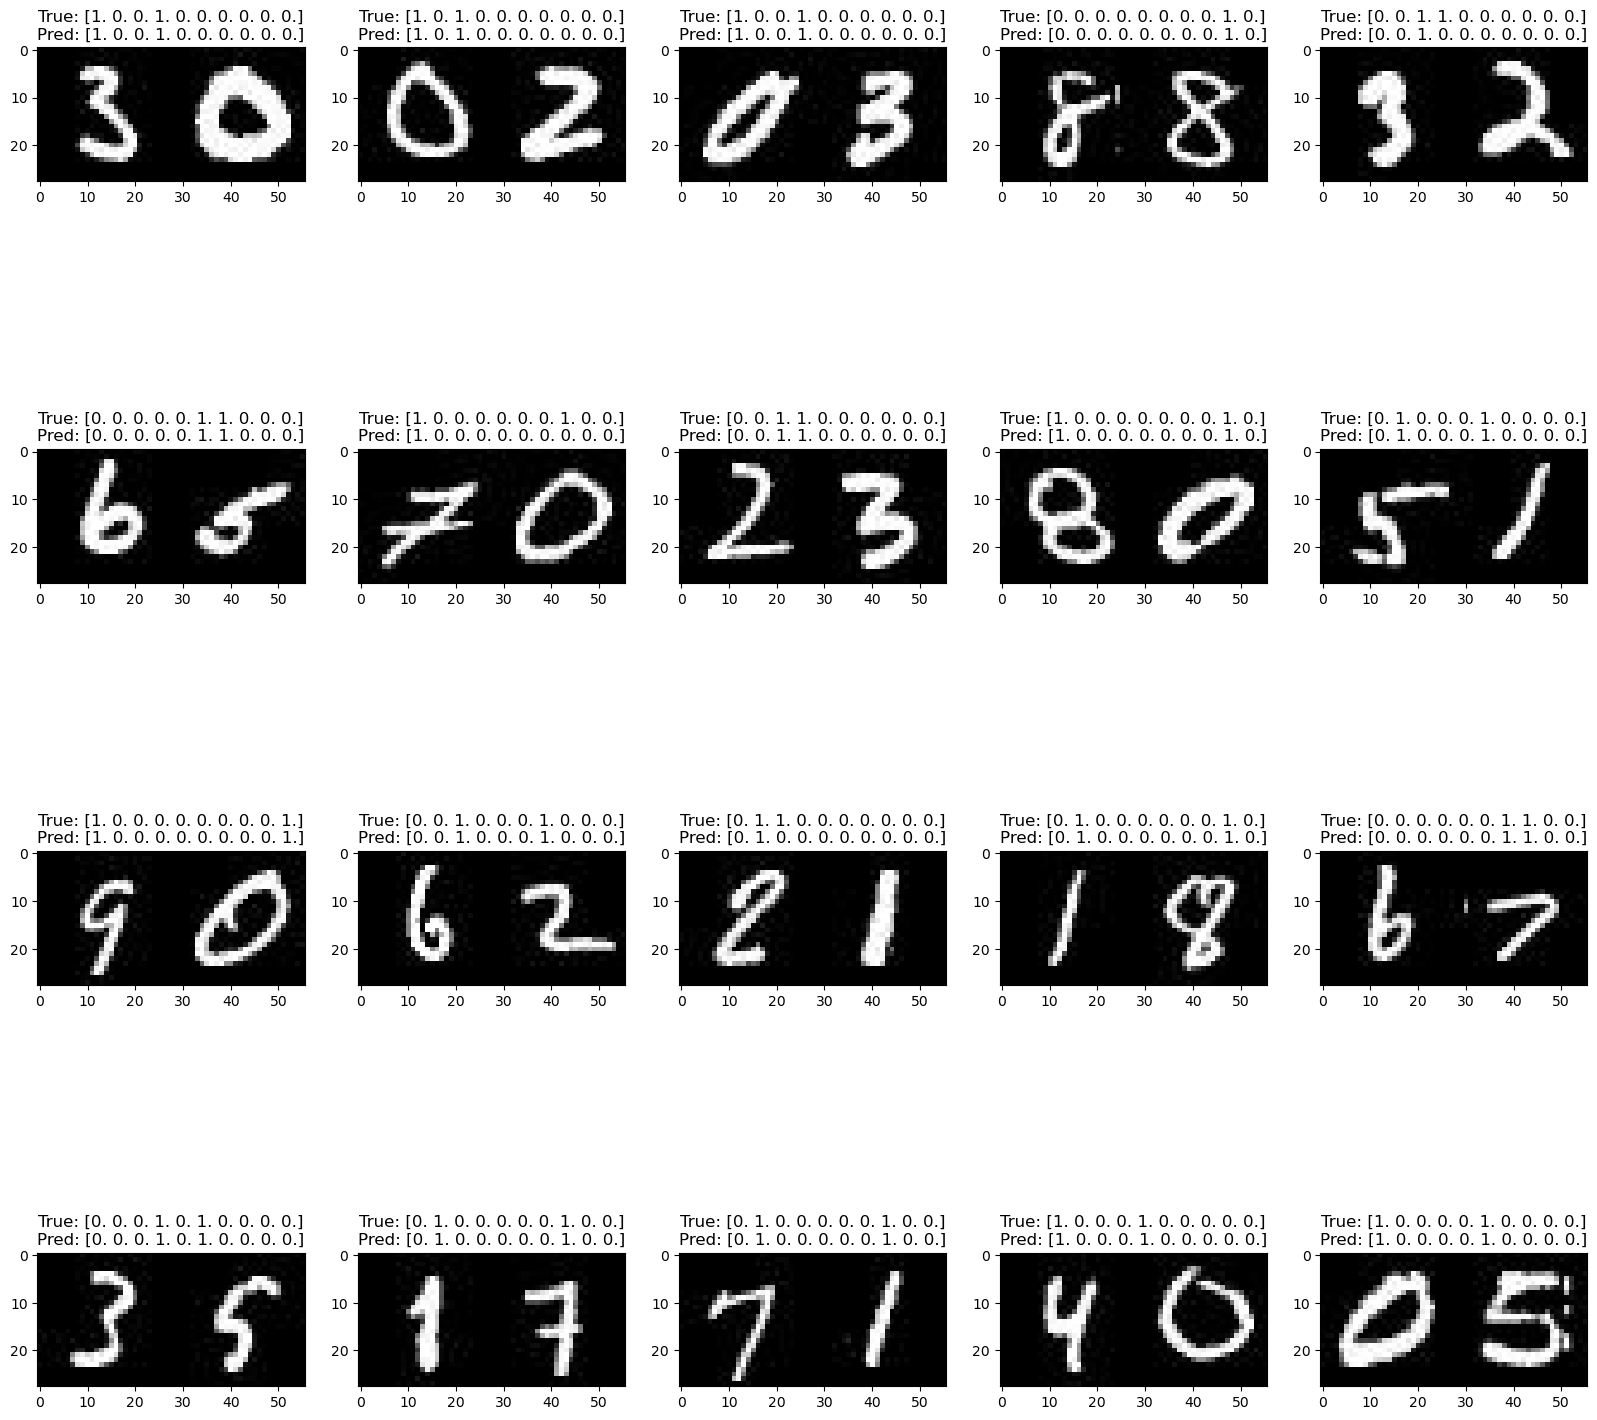

In [17]:
plt.figure(figsize=(20, 20))

for i in range(20):
    plt.subplot(4, 5, i+1)
    img = test_dataset[i][0]
    plt.imshow(img.permute(1, 2, 0))
    label = total_labels[i]
    pred = total_preds[i]
    plt.title(f'True: {label}\nPred: {pred}')